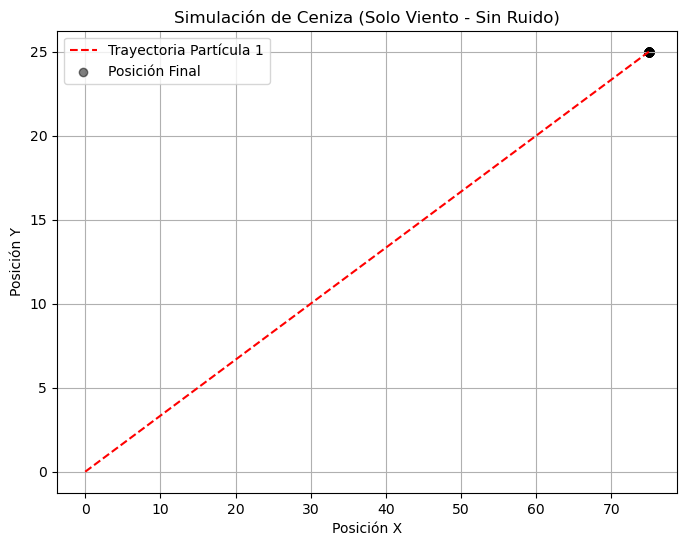

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 100
DT = 1.0          # Paso de tiempo
TIEMPO_TOTAL = 50 # Pasos totales

# --- INICIALIZACIÓN ---
# Crear array de posiciones (N filas, 2 columnas: x, y)
# Todas empiezan en (0,0)
posiciones = np.zeros((N_PARTICULAS, 2))

# Definir viento (velocidad constante en x, y)
viento = np.array([1.5, 0.5]) 

# --- HISTORIAL PARA GRAFICAR ---
# Guardaremos la posición de todas las partículas en cada paso
historial = [posiciones.copy()]

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    # 1. Mover partículas (Solo advección por viento por ahora)
    # pos_nueva = pos_vieja + (viento * dt)
    posiciones = posiciones + (viento * DT)
    
    # 2. Guardar estado
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
# Convertir historial a array para facilitar el plot
historial = np.array(historial) # Forma: (Pasos, N, 2)

plt.figure(figsize=(8,6))

# Graficar la trayectoria de la primera partícula como ejemplo
plt.plot(historial[:, 0, 0], historial[:, 0, 1], 'r--', label='Trayectoria Partícula 1')

# Graficar la posición FINAL de todas las partículas
# (Como no hay ruido aleatorio aun, todas estarán en el mismo punto)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], alpha=0.5, c='black', label='Posición Final')

plt.grid(True)
plt.legend()
plt.title("Simulación de Ceniza (Solo Viento - Sin Ruido)")
plt.xlabel("Posición X")
plt.ylabel("Posición Y")
plt.show()

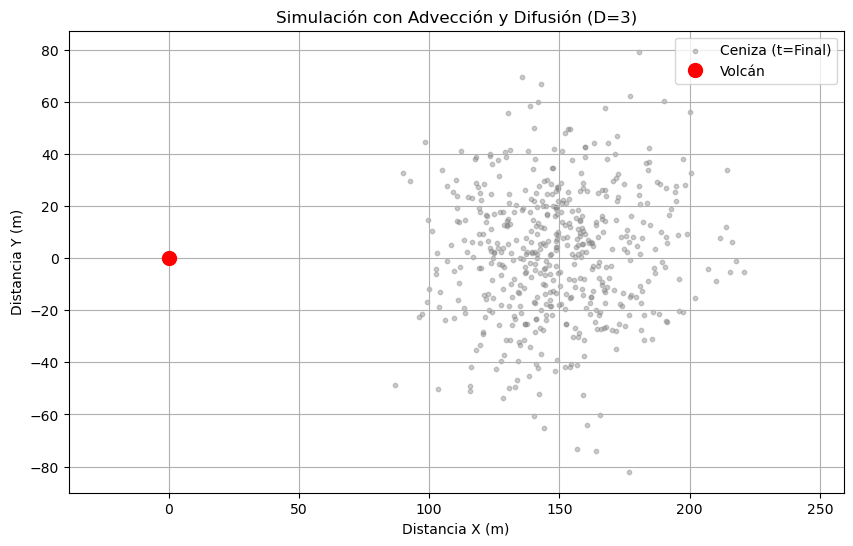

In [5]:
# --- CONFIGURACIÓN ---
N_PARTICULAS = 500  # <--- AUMENTAMOS ESTO para ver una nube densa
DT = 1.0            
TIEMPO_TOTAL = 100  # Más tiempo para ver la expansión
D = 3         # <--- NUEVO: Coeficiente de Difusión (fuerza de la turbulencia)

# --- INICIALIZACIÓN ---
posiciones = np.zeros((N_PARTICULAS, 2))
viento = np.array([1.5, 0.0]) # Viento hacia la derecha

historial = [posiciones.copy()]

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    
    # 1. Componente Determinista (El Viento arrastra)
    adveccion = viento * DT
    
    # 2. Componente Estocástica (El Caos) <--- ¡LA MAGIA OCURRE AQUÍ!
    # Generamos un empujón aleatorio para CADA partícula
    # La magnitud del ruido escala con la raíz cuadrada del tiempo (std = sqrt(2*D*dt))
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(loc=0.0, scale=std_dev, size=(N_PARTICULAS, 2))
    
    # 3. Sumar todo: Nueva Pos = Vieja + Viento + Ruido
    posiciones = posiciones + adveccion + ruido
    
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
historial = np.array(historial) 

plt.figure(figsize=(10,6))

# Graficamos todas las partículas en el paso final
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], 
            alpha=0.4, s=10, c='gray', label='Ceniza (t=Final)')

# Graficamos el punto de origen
plt.plot(0, 0, 'ro', markersize=10, label='Volcán')

plt.grid(True)
plt.legend()
plt.title(f"Simulación con Advección y Difusión (D={D})")
plt.xlabel("Distancia X (m)")
plt.ylabel("Distancia Y (m)")
plt.axis('equal') # Para no deformar la visualización
plt.show()

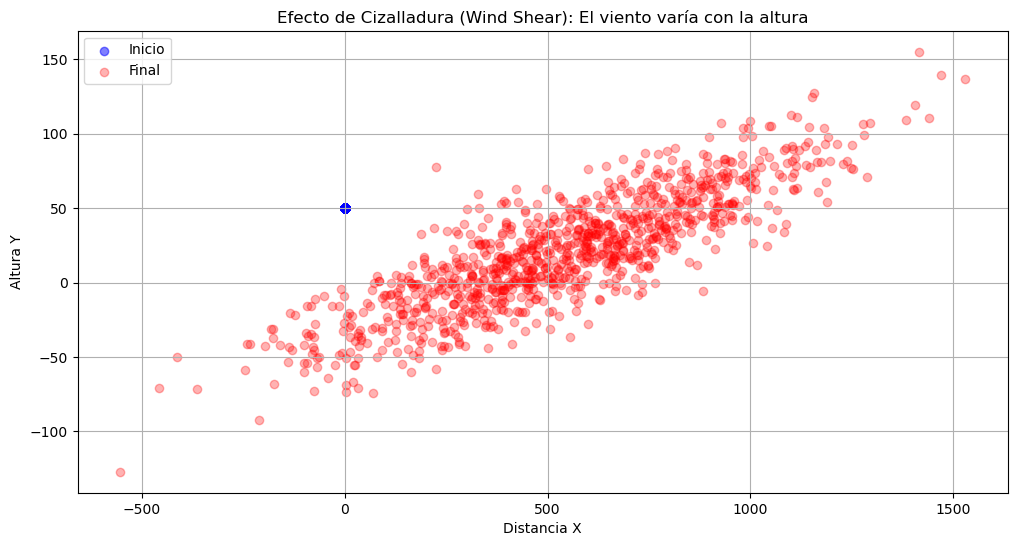

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 1000
DT = 1.0
TIEMPO_TOTAL = 150
D = 5.0 # Difusión

# --- INICIALIZACIÓN ---
# Todas nacen en x=0, y=50 (Altura media para ver cómo el viento varía arriba y abajo)
posiciones = np.zeros((N_PARTICULAS, 2)) + [0.0, 50.0] 
historial = [posiciones.copy()]

# --- FUNCIÓN DE CAMPO DE VIENTO ---
def obtener_viento(posiciones):
    """
    Calcula el vector de viento para cada partícula dependiendo de su altura (y).
    Modelo: 'Wind Shear' (Cizalladura).
    El viento es más fuerte a mayor altura.
    """
    # Extraemos las alturas (columna 1)
    alturas = posiciones[:, 1]
    
    # Velocidad X: Aumenta con la altura (0.1 * altura)
    vx = 0.1 * alturas 
    
    # Velocidad Y: Supongamos que hay una ligera corriente hacia abajo (gravedad/sedimentación)
    vy = np.full(alturas.shape, -0.2) 
    
    # Apilamos vx y vy para tener la forma (N, 2)
    return np.column_stack((vx, vy))

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    
    # 1. Calcular el viento LOCAL para cada partícula
    viento_local = obtener_viento(posiciones)
    
    # 2. Advección
    adveccion = viento_local * DT
    
    # 3. Difusión (Ruido)
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(0, std_dev, size=(N_PARTICULAS, 2))
    
    # 4. Actualizar
    posiciones = posiciones + adveccion + ruido
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
historial = np.array(historial)

plt.figure(figsize=(12,6))

# Graficamos estado inicial (Azul)
plt.scatter(historial[0, :, 0], historial[0, :, 1], c='blue', alpha=0.5, label='Inicio')

# Graficamos estado final (Rojo)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], c='red', alpha=0.3, label='Final')

plt.title("Efecto de Cizalladura (Wind Shear): El viento varía con la altura")
plt.xlabel("Distancia X")
plt.ylabel("Altura Y")
plt.grid(True)
plt.legend()
plt.show()